In [1]:
from data import *
from config import *
from model_classifer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Random seed set to 333
using device:  cpu


In [2]:
# # ---- update configs ----
# overwrite = False
# model_name = 'binary_hr_death'
# text_config['cl']['die7d'] = True # udpate text_config here if needed
# txt_ls = ['will die', 'will survive']

# update_config(
#     model_name = model_name,
#     ts_aug = False,
#     ts_normalize = False,
#     ts_encode = False,
#     balance = False,
#     block_target = False,
#     txt_ls = txt_ls,
#     patience = 10,
#     num_saves = 20,
#     num_epochs = 100,
#     text_config = text_config
# )
# config_dict = get_config_dict()
# config_dict

In [3]:
# -----------------Train Data-----------------
# ---- raw data ----
df = pd.read_csv('../../data/HR_events.csv')
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df = gen_text_input_column(df, config_dict['text_config'])
df['label'] = df.index.to_series()
df['rowid'] = df.index.to_series() # rowid indicate the augmentation mapping to the original data
# ---- augmented data ----
df_aug = pd.read_csv('../../data/hr_aug.csv')
df_raw = pd.read_csv('../../data/HR_events.csv')
df_raw['rowid'] = df_raw.index.to_series()
df_aug = df_aug.merge(df_raw[['rowid', 'VitalID','VitalTime']], on='rowid', how='left')
df_aug = df_aug.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df_aug = label_death7d(df_aug, df_y, id_col='VitalID')
df_aug = df_aug.merge(df_demo, on='VitalID', how='left')
df_aug = gen_text_input_column(df_aug, config_dict['text_config'])
df_aug['label'] = df_aug.index.to_series()
# replace all column names from ['X1':'X300'] to '1' : '300'
rename_dict = {f'X{i}': str(i) for i in range(1, 301)}
df_aug = df_aug.rename(columns=rename_dict)
# keep only the columns that are in df




# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_csv('../../data/Test Data/hr_test.csv') # test hr with description
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)
df_test = gen_text_input_column(df_test, config_dict['text_config'])
df_test['label'] = df_test.index.to_series()
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
4978    2
8695    2
1100    1
1189    1
1441    1
dtype: int64
This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  1 Bradycardia90 event (heart rate below 90) happened.  Event 1: There was a Bradycardia90 event from time 279 to time 283. 

Sample of patients with positive labels:
VitalID
8695    97
4978    55
1189    50
1647    50
1979    50
dtype: int64
This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  1 Bradycardia90 event (heart rate below 90) happened.  Event 1: Since time 267, the heart rate began to drop, falling below 90 beats per minute at time 277, and remained below 90 for the next 6 time points. 

Sample of patients with positive labels:
TestID
571     3
516     2
801     2
2530    2
226     1
dtype: int64
This infant will survive.  This infant has gestational age 25 weeks. Birth weight is 700 grams.  1 Bradycardia80 event (heart rate 

In [4]:
# ---- augment + balance ----
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
df_train = df
if config_dict['ts_aug']:
    df_train = augment_data(df_train, df_aug, txt_ls_org, balance=config_dict['balance'])
    
# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df

y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)

y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")


(1849, 300)
(693, 300)
Number of positives in y_true_train: 16
Number of positives in y_true_test: 10


# baseline models to predict clinical outcomes end2end

In [ ]:
# Create different types of models
resnet_encoder = ResNetEncoder(ts_dim=300, hidden_dim=64, num_blocks=8, dropout=0.5)
model = GeneralBinaryClassifier(resnet_encoder)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=20,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)


Layer (type:depth-idx)                        Param #
GeneralBinaryClassifier                       --
├─ResNetEncoder: 1-1                          --
│    └─Sequential: 2-1                        --
│    │    └─Linear: 3-1                       19,264
│    │    └─BatchNorm1d: 3-2                  128
│    │    └─LeakyReLU: 3-3                    --
│    │    └─Dropout: 3-4                      --
│    │    └─ResidualBlock: 3-5                8,576
│    │    └─ResidualBlock: 3-6                8,576
│    │    └─ResidualBlock: 3-7                8,576
│    │    └─ResidualBlock: 3-8                8,576
│    │    └─ResidualBlock: 3-9                8,576
│    │    └─ResidualBlock: 3-10               8,576
│    │    └─ResidualBlock: 3-11               8,576
│    │    └─ResidualBlock: 3-12               8,576
│    │    └─Linear: 3-13                      4,160
│    │    └─BatchNorm1d: 3-14                 128
├─Linear: 1-2                                 130
Total params: 92,418
Trainable

Epoch [1/1000]
	Train Loss: 0.7499	Test Loss: 0.7330
	Train F1: 0.0150	Test F1: 0.0302
	Train AUROC: 0.5691	Test AUROC: 0.4578
	Train AUPRC: 0.0158	Test AUPRC: 0.0142
	Learning Rate: 0.000050000
Epoch [2/1000]
	Train Loss: 0.7379	Test Loss: 0.7239
	Train F1: 0.0163	Test F1: 0.0319
	Train AUROC: 0.5787	Test AUROC: 0.4898
	Train AUPRC: 0.0153	Test AUPRC: 0.0153
	Learning Rate: 0.000050000
Epoch [3/1000]
	Train Loss: 0.7259	Test Loss: 0.7074
	Train F1: 0.0202	Test F1: 0.0264
	Train AUROC: 0.5817	Test AUROC: 0.4898
	Train AUPRC: 0.0155	Test AUPRC: 0.0154
	Learning Rate: 0.000050000
Epoch [4/1000]
	Train Loss: 0.7236	Test Loss: 0.7186
	Train F1: 0.0167	Test F1: 0.0325
	Train AUROC: 0.5824	Test AUROC: 0.4919
	Train AUPRC: 0.0151	Test AUPRC: 0.0155
	Learning Rate: 0.000050000
Epoch [5/1000]
	Train Loss: 0.7141	Test Loss: 0.7069
	Train F1: 0.0196	Test F1: 0.0256
	Train AUROC: 0.5795	Test AUROC: 0.4930
	Train AUPRC: 0.0148	Test AUPRC: 0.0156
	Learning Rate: 0.000050000
Epoch [6/1000]
	Train Los

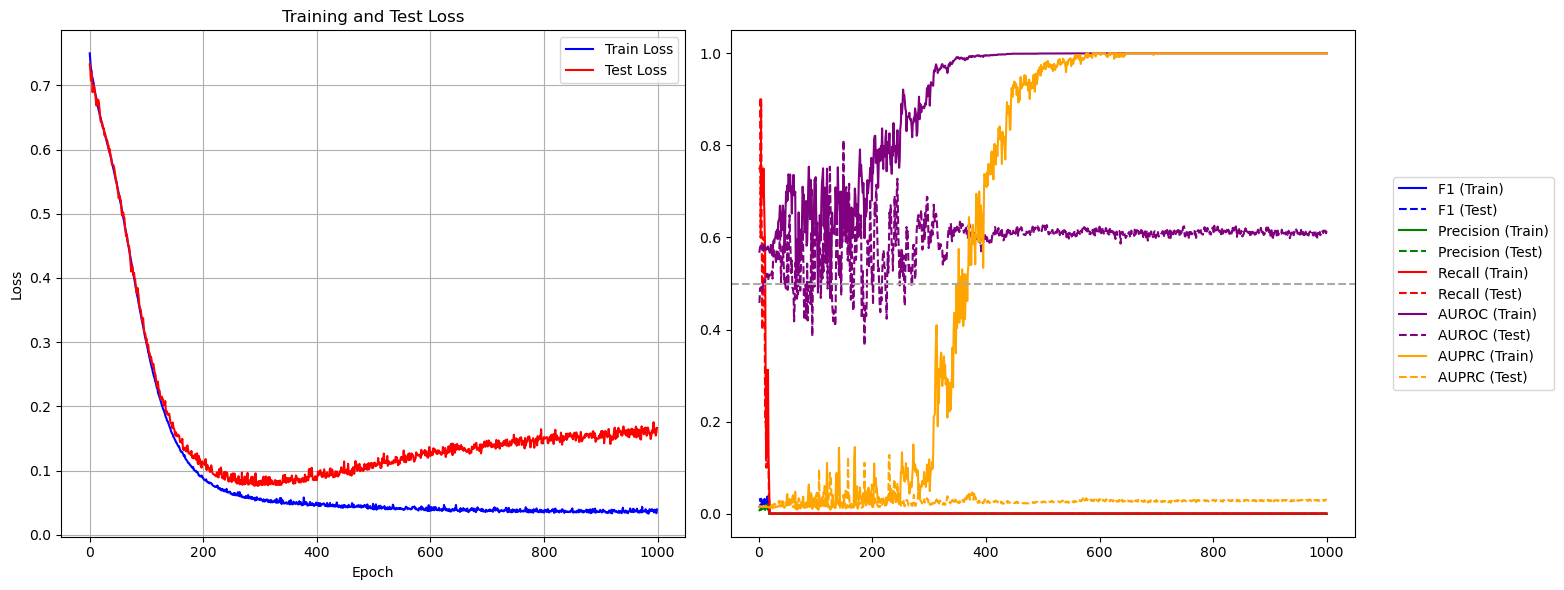

In [10]:

eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
                                                train_loader,
                                                test_loader, 
                                                optimizer, 
                                                scheduler,
                                                1000, 
                                                device)
eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True)

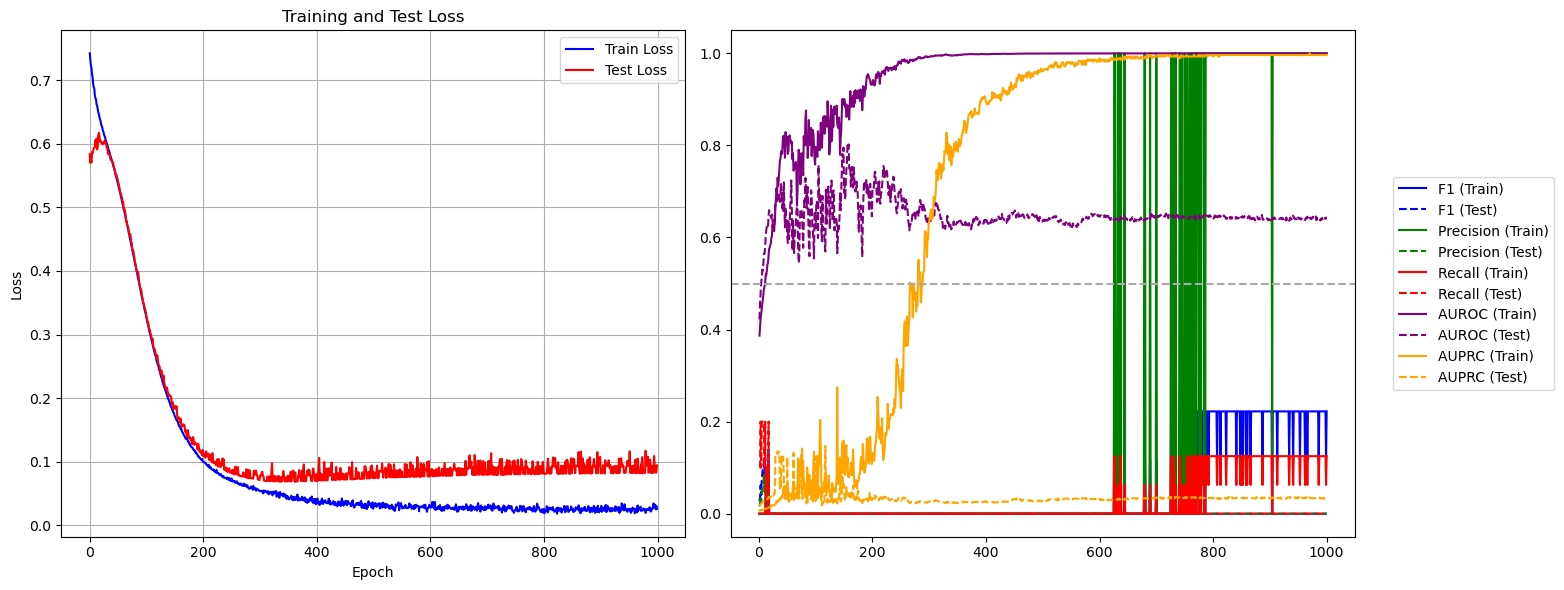

In [7]:

eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True, plot_confusion_matrices=True)

In [ ]:

# train_eval_metrics_list = []
# test_eval_metrics_list = []
# train_losses = []
# test_losses = []

# if overwrite or not os.path.exists(model_path):
    
#     for i in range(config_dict['num_saves']): 
#         eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
#                                                 train_loader,
#                                                 test_loader, 
#                                                 optimizer, 
#                                                 scheduler,
#                                                 config_dict['num_epochs'], 
#                                                 device)
#         train_losses = train_losses + train_losses_tmp
#         test_losses = test_losses + test_losses_tmp

#         train_metrics, test_metrics = eval_binary_classifier(model, 
#                                                              train_loader, 
#                                                              test_loader, 
#                                                              device)
#         train_eval_metrics_list.append(train_metrics)
#         test_eval_metrics_list.append(test_metrics)
#         # save model and losses
#         torch.save(model.state_dict(), model_path)
#         torch.save({'train_losses': train_losses, 
#                     'test_losses': test_losses, 
#                     'train_evals': train_eval_metrics_list, 
#                     'test_evals': test_eval_metrics_list}, eval_path)
#         if i % 10 == 0: # every 10 saves, evaluate the model
#             eval_dict = torch.load(eval_path)
#             eval_dict_eng = eng_eval_metrics(eval_dict, binary=True)
#             print("-" * 70)
#             print(f"Metric     |  Training  |  Testing")
#             print("-" * 70)
#             print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
#             print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
#             print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
#             print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
#             print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
#             print("-" * 70)
    
# else:
#     model.load_state_dict(torch.load(model_path))
#     eval_dict = torch.load(eval_path)
#     train_losses = eval_dict['train_losses']
#     test_losses = eval_dict['test_losses']
#     train_eval_metrics_list = eval_dict['train_evals']
#     test_eval_metrics_list = eval_dict['test_evals']
#     eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=True)